# Guía 8 - Pronósticos de demanda diaria con LSTM usando Keras y TensorFlow

## Pronósticos a partir de la serie temporal de la demanda diaria incorporando variables exógenas

La propuesta es dar pronósticos de la demanda diaria de energía eléctrica a partir de sus valores registrados en días anteriores y de otros atributos que podrían tener influencia (variables exógenas). Obtendremos los pronósticos a partir del entrenamiento de redes neuronales (Neural Networks, NN) usando celdas del tipo Long-Short-Time-Memory (LSTM) y de otras configuraciones incorporando las variables exógenas.

Continuaremos con nuestro ejemplo tomando la base de datos de demanda diaria de energía eléctrica publicados por CAMMESA. 

## Inicio de la programación para el análisis y pronóstico de la serie temporal

Comenzamos importando las bibliotecas necesarias y confirmamos la versión de TensorFlow (TF) disponible en la instalación. Esto nos puede ayudar a interpretar algunas diferencias en el comportamiento de las funciones de TF.

In [1]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import keras
import tensorflow as tf
tf.random.set_seed(99)
print(tf.__version__)

2.18.0


## Carga del conjunto de datos para su análisis

Cargamos los datos de demanda diaria. DEMANDA TOTAL es la serie que queremos predecir (target). Esperamos que sus valores históricos nos provean información para su pronóstico. Además, tomaremos otros atributos que consideramos relevantes como `TEMPERATURA REFERENCIA MEDIA GBA °C` o `Tipo día` que nos informa si la jornada fue laborable, semilaborable o no laborable. Las columnas que se refieren a los registros de demanda para otras regiones argentinas no las consideraremos.

In [2]:
# Dataset loading
dataFrame = pd.read_excel('Data/Base Demanda Diaria 2017 2024.xlsx', sheet_name='Datos Región', skiprows=4)  
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   AÑO                                  2891 non-null   int64         
 1   MES                                  2891 non-null   datetime64[ns]
 2   Fecha                                2891 non-null   datetime64[ns]
 3   Tipo día                             2891 non-null   object        
 4   GRAN BS.AS.                          2891 non-null   float64       
 5   BUENOS AIRES                         2891 non-null   float64       
 6   CENTRO                               2891 non-null   float64       
 7   LITORAL                              2891 non-null   float64       
 8   CUYO                                 2891 non-null   float64       
 9   NOROESTE                             2891 non-null   float64       
 10  NORESTE     

### Separación de los conjuntos de datos de entrenamiento y prueba

Como es habitual, separamos el conjunto de datos en entrenamiento y prueba. Como sabemos, se reserva una porción del final de la serie temporal como datos de prueba. En este ejercicio, desdoblamos en datos numéricos y categóricos.

In [3]:
train_len_rate = 0.9
len_df = len(dataFrame)

# TensorFlow tensors require that all elements have the same dtype.
numeric_feature_names = ['DEMANDA TOTAL', 'TEMPERATURA REFERENCIA MEDIA GBA °C']
column_indices = {name: i for i, name in enumerate(numeric_feature_names)}
numeric_tensor = np.float32(dataFrame[numeric_feature_names].to_numpy())
# cast to tf defaults... float32

categoric_feature_names = ['Tipo día']
categoric_tensor = dataFrame[categoric_feature_names].to_numpy()

train_num = numeric_tensor[:int(train_len_rate * len_df)]
train_cat = categoric_tensor[:int(train_len_rate * len_df)]

test_num = numeric_tensor[int(train_len_rate * len_df):]
test_cat = categoric_tensor[int(train_len_rate * len_df):]
print(train_cat.dtype)

object


## Ventanas de datos

Necesitamos particionar la serie temporal en lotes operables por las sucesivas capas de NN. Es importante notar que dentro de cada lote se conserva el orden temporal...

In [4]:
# Single step dataset preparation
# The input of LSTM layer has a shape of (num_timesteps, num_features)
def singleStepSampler(df, window, target_idx=0):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            res.append(df[i+j,:])
        xRes.append(res)
        yRes.append(df[i + window,target_idx])
    return tf.convert_to_tensor(xRes), tf.convert_to_tensor(np.array(yRes))

Aplicamos las ventanas a los datos de prueba y entrenamiento. Dentro de cada ventana se arman lotes de datos de tamaño BATCH_SIZE. Así, `X` guardará la información de los días previos de la demanda y otras variables numéricas, mientras que `y` almacenará la predicción de demanda para el día siguiente. Además, `cat` representará la información categórica.

In [5]:
# un ciclo completo de 4 semanas
# igual cantidad de instancias de lunes que de domingos (4)
BATCH_SIZE = 28 

(X_train, y_train) = singleStepSampler(train_num, BATCH_SIZE)
cat_train = singleStepSampler(train_cat, BATCH_SIZE)[0]
(X_test, y_test) = singleStepSampler(test_num, BATCH_SIZE)
cat_test = singleStepSampler(test_cat, BATCH_SIZE)[0]

y_train = y_train[...,tf.newaxis]
y_test = y_test[...,tf.newaxis]

Confirmamos los tamaños de los nuevos conjuntos de datos particionados en lotes de tamaño `BATCH_SIZE`.

In [6]:
print(X_train.shape)
print(cat_train.shape)
print(y_train.shape)

print(X_test.shape)
print(cat_test.shape)
print(y_test.shape)

(2573, 28, 2)
(2573, 28, 1)
(2573, 1)
(262, 28, 2)
(262, 28, 1)
(262, 1)


## Preprocesamiento con TensorFlow

La propuesta es realizar el preprocesamiento con los métodos y herramientas provistos por TensorFlow. Esto tiene la ventaja de que puede añadirse dentro del flujo del modelo. Otro camino alternativo es utilizar `pipeline` y `ColumnTransformer` de SciKit-Learn. 

### Capas de preprocesamiento de TensorFlow

En primer lugar, debemos tener en cuenta que los `tf.tensor` solo puden almacenar valores de un mismo tipo `dtype` (al igual que los `np.array`). Este es el motivo detrás de la separación de las columnas que ya practicamos en el `pd.DataFrame` entre datos numéricos y categóricos. En adelante, cuando los datos son de tipos heterogéneo, deberán preprocesarse de manera particular. Esto puede realizarse de dos maneras difrentes con las herramientas de TF.

Por un lado, se puede adelantar todo el preprocesado conviertientdo los datos a `tf.data.Dataset` o usar `tf.Transform`: ver por ejemplo [Preprocessing data with TensorFlow Transform](https://www.tensorflow.org/tfx/tutorials/transform/census).

Por otro lado, TF permite incluir el preprocesado dentro de las primeras capas del modelo: ver por ejemplo [Load a pandas DataFrame](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe). Nosotros abordaremos esta segunda estrategia.

El artículo [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) ejemplifica el uso de `layers` de Keras para su preprocesado independiente e incluye atributos numéricos y categóricos. Nosotros seguiremos un tratamiento similar aprovechando `layers` ya definidos como `tf.keras.layers.Normalization` y `tf.keras.layers.StringLookup` explicadas en [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers). Además, deberemos crear nuestras propias capas de preprocesado inspirados por [Building a One Hot Encoding Layer with TensorFlow](https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39). 



### Utilizando la capa de normalización

Vamos a dar un ejemplo sobre cómo opera la capa de `tf.keras.layers.Normalization` (disponible en versiones de TF recientes). Como su nombre lo sugiere, normaliza los datos numéricos. Debemos anticiparle los datos que procesará para que estime los estadísticos adecuados que usará en el escalado. Esto lo realiza el método `.adapt()`. Bśicamente, realiza una transformación afín calculando previamente la media y la desviación estandard en la dirección del eje (`axis`) definido.

In [7]:
# Normalize numeric features
normalize_layer = keras.layers.Normalization(axis=2)
normalize_layer.adapt(X_train)
normalize_layer.get_config()

{'name': 'normalization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'axis': (2,),
 'invert': False,
 'mean': None,
 'variance': None}

Aquí damos un ejemplo del escalado del primer registro del primer lote de entrenamiento

In [8]:
normalize_layer(X_train[0,0])


<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.20526236, 2.1724534 ]]], dtype=float32)>

Podemos conocer la media y la varianza que luego podríamos usar para invertir los resultados

In [9]:
print('DEMANDA TOTAL - Mean: {0:.0f}, Std.Dev {1:.0f}'.format(normalize_layer.mean[0,0,0],
                                                           np.sqrt(normalize_layer.variance[0,0,0])))
print('Temperatura - Mean: {0:.1f}, Std.Dev. {1:.1f}'.format(normalize_layer.mean[0,0,1],
                                                             np.sqrt(normalize_layer.variance[0,0,1])))

DEMANDA TOTAL - Mean: 15269, Std.Dev 2067
Temperatura - Mean: 18.9, Std.Dev. 5.7


Agregamos un ejemplo de inversión

In [10]:
unnormalize_layer = keras.layers.Normalization(axis=2, mean=normalize_layer.mean,
                                              variance=normalize_layer.variance, invert=True)
unnormalize_layer(tf.constant([[[0,0]]]))


<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[15269.473   ,    18.860168]]], dtype=float32)>

Obviamente, como pasamos como argumento el `0,0` recuperamos los valores medios de demanda y temperatura

## Operando con una capa de One-Hot-Encoding

Vamos a dar un ejemplo sobre cómo opera la capa de `tf.keras.layers.StringLookup` (disponible en versiones de TF recientes) buscando transformar el atributo `Tipo día` en atributos tipo one-hot.

Analizamos cuántos registros hay por `Tipo día`. 

In [11]:
day, idx, count = tf.unique_with_counts(tf.reshape(cat_train, [-1]))
for a, b in zip(day, count):
    print('Días: {} Cantidad: {}'.format(a,b))

Días: b'Domingo o Feriado' Cantidad: 13487
Días: b'Lunes habiles' Cantidad: 8918
Días: b'Martes Habiles' Cantidad: 9759
Días: b'Miercoles habiles' Cantidad: 10096
Días: b'Jueves Habiles' Cantidad: 9928
Días: b'Viernes habiles' Cantidad: 9564
Días: b'Sabado o Semilaborable' Cantidad: 10292


Ahora probamos la capa para entender un poco más su operación. Creamos la capa informando que encontrará 7 tokens (uno por día de la semana),  sin *out-of-vocabulary* (aunque podría dejarse en un valor positivo para detectar errores). Forzamos la codificación tipo *one-hot*. Por default asigna un entero a cada término diferente. Luego se debe crear el vocabulario ejecutando el método `.adapt()`.

In [12]:
max_tokens = len(day)

lookup_layer = tf.keras.layers.StringLookup(
    max_tokens=max_tokens,
    num_oov_indices=0,
    mask_token=None,
    vocabulary=None,
    # output_mode='int'
    output_mode='one_hot'
)

lookup_layer.adapt(cat_train)
lookup_layer.get_vocabulary()

[np.str_('Domingo o Feriado'),
 np.str_('Sabado o Semilaborable'),
 np.str_('Miercoles habiles'),
 np.str_('Jueves Habiles'),
 np.str_('Martes Habiles'),
 np.str_('Viernes habiles'),
 np.str_('Lunes habiles')]

Vemos como transforma la serie con información categórica en 7 columnas de tipo entero.

In [13]:
lookup_layer(cat_train)

<tf.Tensor: shape=(2573, 28, 7), dtype=int64, numpy=
array([[[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0

Con el siguiente ejemplo confirmamos cómo transforma el atributo de `Tipo día` asignando un 1 a una de las 7 columnas correspondientes a cada día de la semana.

In [14]:
print(train_cat[0,0])

Domingo o Feriado


In [15]:
lookup_layer('Domingo o Feriado')

<tf.Tensor: shape=(1, 7), dtype=int64, numpy=array([[1, 0, 0, 0, 0, 0, 0]])>

El orden dado a las columnas es compartido con el orden del vocabulario.

## Construyendo una capa custom de preprocesado

Resumidamente, la capa custom necesita definir un método `.call()` que se ejecutará dentro del modelo y un método `.adapt()` para configurar los parámetros de la capa custom. Previamente, inicializamos la capa `StringLookup` que nos permitirá transformar los valores categóricos en one-hot. Aquí proponemos una capa custom tipo one-hot para agrupar todos los días laborables en una misma clase. Proponemos, más adelante,  un ejercio que usa la capa `tf.keras.layers.StringLookup` sin modificar, de manera que asigna individualmente un one-hot a cada día de la semana.

In [16]:
# Our definition for the categorical preporcossing layer
class OneHotPre(keras.layers.Layer):
    def __init__(self, index, max_tokens, vocabulary=None, num_oov_indices=0, **kwargs):
        self._index = index
        self._lookup_layer = tf.keras.layers.StringLookup(
            max_tokens = max_tokens,
            num_oov_indices = num_oov_indices,
            vocabulary = vocabulary,
            # output_mode = 'int'
            output_mode = 'one_hot')
        super().__init__(**kwargs)
    def _to_day_type(self, value):
        day_type = tf.strings.lower(value)
        day_type = tf.strings.regex_replace(day_type, '^.*h.bil.*$', 'laborable')
        day_type = tf.strings.regex_replace(day_type, '^.*semilaborable.*$', 'semilaborable')
        return tf.strings.regex_replace(day_type, '^.*feriado.*$', 'nolaborable')
    def adapt(self, data_sample):
        self._lookup_layer.adapt(self._to_day_type(data_sample[:,:,self._index]))
    def call(self, inputs):
        return self._lookup_layer(self._to_day_type(inputs[:,:,self._index]))
    def get_config(self):
        return {'vocabulary': self._lookup_layer.get_vocabulary()}



La variable index permite seleccionar la columna a la que queremos aplicar one-hot (aquí es solo una columna). La cantidad de tokens es 3 ya que definimos 3 tipos de día: laborable, semilaborable, y no laborable.

Debemos anticipar a las capas *custom* qué datos recibirán. El método `adapt()` prepara a la capa antes de ser usada por dentro del modelo. 

In [17]:
index=0
one_hot_layer = OneHotPre(index, 3)
one_hot_layer.adapt(cat_train)
one_hot_layer.get_config()


{'vocabulary': [np.str_('laborable'),
  np.str_('nolaborable'),
  np.str_('semilaborable')]}

## Definición del modelo usando la Functional API

Functional API es otro método para definir un modelo de NN que permite abrir varios flujos de información habilitando tratamientos específicos en canales diferentes. Enfatiza la definición de entradas y salidas.

En este caso, definimos el modelo de manera que procese la información de entrada por 2 canales diferentes. Los datos numéricos se normalizan, los categóricos pasan por la capa custom de codificación one-hot. Luego, ambas salidas se unen para continuar su procesamiento en la primer capa con celdas LSTM. 


In [18]:
# Functional API Model 
numeric_input = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), dtype=tf.float32)
normalized = normalize_layer(numeric_input)
categorical_input = keras.layers.Input(shape=(cat_train.shape[1], cat_train.shape[2]), dtype=tf.string)
encoded = one_hot_layer(categorical_input)
concat = keras.layers.concatenate([normalized, encoded])
lstm_lyr = keras.layers.LSTM(10)(concat)
dropout_lyr = keras.layers.Dropout(0.2)(lstm_lyr)
dense_lyr = keras.layers.Dense(1, activation='linear')(dropout_lyr)
model_exo = keras.models.Model(inputs=[numeric_input, categorical_input], outputs=[dense_lyr])
model_exo.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_exo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 28, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 28, 2)     │          5 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_hot_pre         │ (None, 28, 3)     │          0 │ input_layer_1[0]… │
│ (OneHotPre)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 5)     │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ one_hot_pre[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10)        │        640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         11 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 656 (2.57 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 5 (24.00 B)

El método `.summary()` nos muestra cómo fluirá la información entre las capas de NN y cuántos parámetros se deberán ajustar en cada una. Otra alternativa para representar la configuración de la NN es usar `tf.keras.utils.plot_model`.

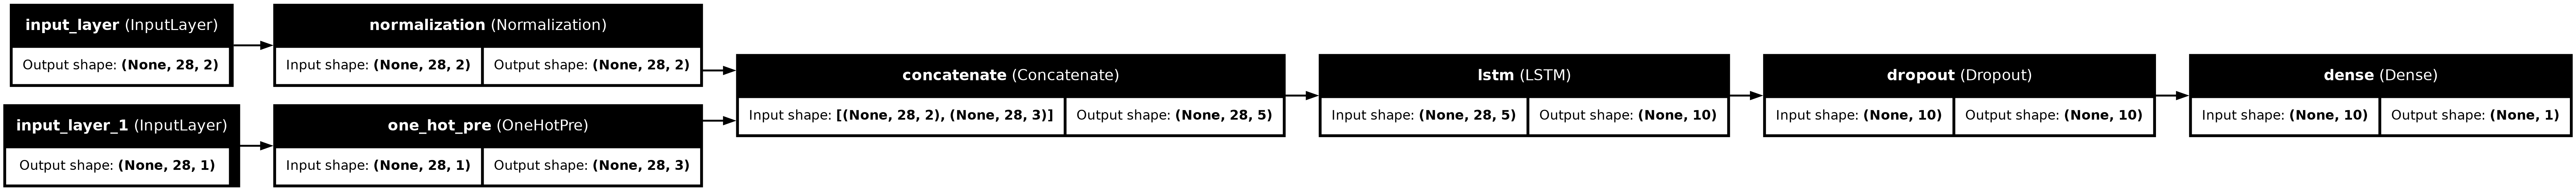

In [19]:
tf.keras.utils.plot_model(model_exo, to_file='Figs/model.png', rankdir="LR", show_shapes=True,  show_layer_names=True)

#tf.keras.utils.plot_model(multivariate_lstm, to_file='Figs/model.png', show_shapes=True,
#                          show_dtype=True, show_layer_names=True, rankdir='TB',
#                          expand_nested=True, dpi=200, show_layer_activations=True,
#                          show_trainable=True)

### Ajuste del modelo

Entrenamos el modelo, es decir, ajustamos los pesos de acuerdo al esquema definido cuando fue compilado, por ejemplo optimizer='Adam'

In [20]:
normalize_target = keras.layers.Normalization(axis=1, mean=normalize_layer.mean[0,0,0],
                                              variance=normalize_layer.variance[0,0,0])
# normalize_target(tf.constant([[0]]))

# Model training
history = model_exo.fit([X_train, cat_train], [normalize_target(y_train)], epochs=30, validation_split=0.1)

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# history = model_exo.fit([X_train, cat_train], [y_train], epochs=3000, validation_split=0.1, callbacks=[early_stopping_cb])


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - MAE: 0.8091 - loss: 1.0873 - val_MAE: 0.6846 - val_loss: 0.8785
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAE: 0.6221 - loss: 0.6739 - val_MAE: 0.6012 - val_loss: 0.6255
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAE: 0.5670 - loss: 0.5294 - val_MAE: 0.5627 - val_loss: 0.5462
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAE: 0.5289 - loss: 0.4638 - val_MAE: 0.5254 - val_loss: 0.4854
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - MAE: 0.4866 - loss: 0.4048 - val_MAE: 0.4946 - val_loss: 0.4374
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAE: 0.4752 - loss: 0.3948 - val_MAE: 0.4722 - val_loss: 0.4016
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - MAE: 0.4568 - loss: 0.3612 - val_MAE: 0.4525 - val_loss: 0.3685
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - MAE: 0.4452 - loss: 0.3453 - val_MAE: 0.4370 - val_loss: 0.3434
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.4152

Para tener una idea sobre la convergencia del moelo, mostramos las curvas de aprendizaje

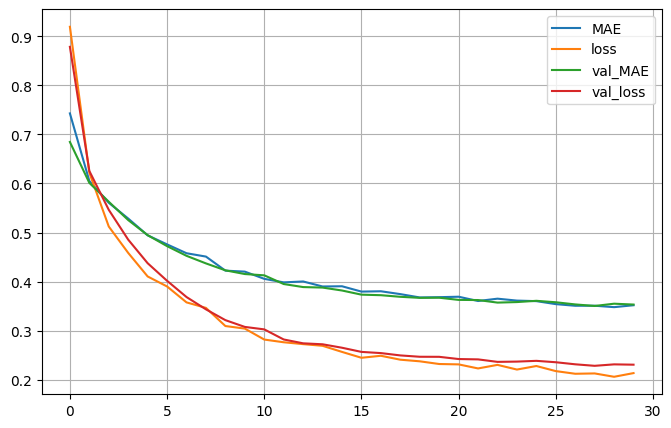

In [21]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
# plt.gca().set_ylim(0,1)

Luego que el modelo ha sido ajustado, es muy fácil obtener nuevas predicciones, como por ejemplo cuando le pasamos el conjunto de prueba.

In [22]:
predicted_values = model_exo.predict([X_test, cat_test])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [23]:
predicted_values.shape

(262, 1)

### Evaluación de los resultados

Ahora vamos a representar nuestro resultado. Construimos un `DataFrame` para almacenar los valores de `DEMANDA TOTAL` predecida y observada, y su fecha (que recuperamos de los datos originales). Este `DataFrame` nos facilitará el cálculo de distintas métricas que califican el grado de acuerdo de las predicciones del modelo con los valores registrados. Asimismo, representaremos en una figura ambas series de datos para tener una estimación visual del desempeño del modelo.  

In [24]:
# Forecast Plot with Dates on X-axis
LSTM_eval = pd.DataFrame({
    'Predicted_DEMANDA': predicted_values[:, 0],
    'Actual_DEMANDA': normalize_target(y_test)[:, 0],
})

LSTM_eval.loc[:, 'Date'] = dataFrame['Fecha'][-len(y_test):].values
# LSTM_eval.set_index('Date', inplace=True)
LSTM_eval['Date'] = pd.to_datetime(LSTM_eval['Date'])
LSTM_eval.set_index('Date', inplace=True)


In [25]:
# Creamos una figura para representar las series de datos
def FigPredActual(d, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    #  highlight the  forecast
    # highlight_start = int(len(d) * 0.9)  
    # highlight_end = len(d) - 1  # Adjusted to stay within bounds
    # Plot the actual values
    # plt.plot(d[['Actual_DEMANDA']][:highlight_start], label=['Actual_DEMANDA'])
    plt.plot(d[['Actual_DEMANDA']], label=['Actual_DEMANDA'])
    
    # Plot predicted values with a dashed line
    plt.plot(d[['Predicted_DEMANDA']], label=['Predicted_DEMANDA'], linestyle='--')
    
    # Highlight the forecasted portion with a different color
    # plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
    
    plt.title(title)
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()

Trazamos ambas series de datos

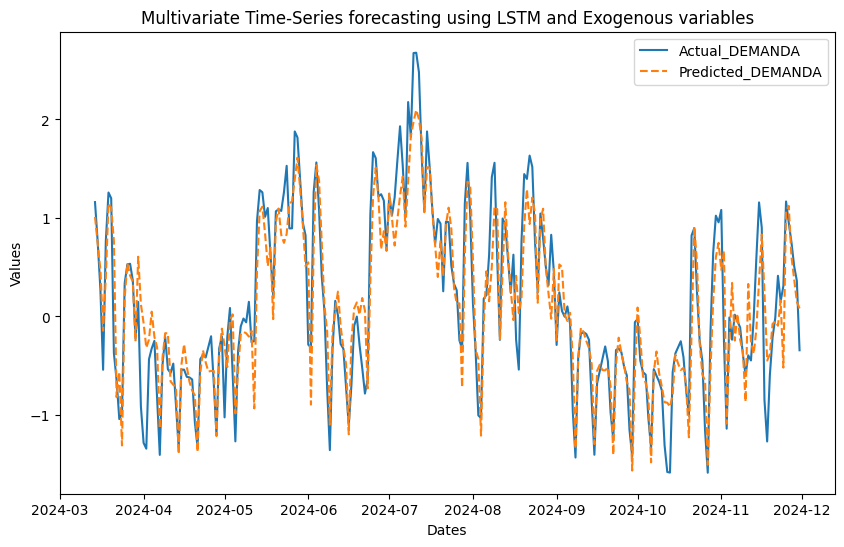

In [26]:
FigPredActual(LSTM_eval, 'Multivariate Time-Series forecasting using LSTM and Exogenous variables')

Definimos una función conveniente para calcular diferentes métrias que nos informan sobre el grado de acuerdo de las predicciones del modelo con las observaciones

In [27]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def performance(d):
    return {
        'MSE': mean_squared_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'MAE': mean_absolute_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'R2': r2_score(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy())
    }

performance(LSTM_eval)

{'MSE': 0.14343629777431488,
 'MAE': 0.2783016860485077,
 'R2': 0.8230663537979126}

**Preguntas**

1. ¿Cómo se comparan las métricas luego de agregar las variables exógenas respecto al caso visto en la guía anterior que solo usa la variable `DEMANDA TOTAL` (o variable endógena)?
2. ¿Sería conveniente usar `keras.callbacks.EarlyStopping`?
3. ¿Se podría tomar la salida del valor pronosticado para incorporarlo a la serie de entrada de manera de pronosticar en más de un paso de tiempo adelante? Más en general, ¿Se podría dar un pronóstico para más de un paso de tiempo futuro? ¿Qué estrategia se podría usar?
4. ¿Se podría sumar la transformación inversa como una capa final del modelo de manera de evitar la transformación del target? Realice una prueba. 

**Ejercicio**

1. Repetir el análisis pero usando `tf.keras.layers.StringLookup` sin modificar, de manera que asigne individualmente un one-hot a cada día de la semana. ¿Tiene un impacto positivo un análisis que consdiere individualemnte cada día de la semana? ¿Se puede saber si hay días específicos de mayor demanda? ¿Se puede estimar la incertidumbre en esa afirmación? 
2. Agregar otras variables exógenas o atributos que representen el paso del tiempo (ej. `pd.Timestamp.timestamp`) como los ciclos del año (funciones armónicas). Evaluar los resultados luego de incluir esta información adicional.
3. Obtener una serie *baseline* a partir de un modelo `Dense` similar al analizado en la guía anterior pero que ahora también incorpore las variables exógenas.